C:\Users\MAGISHA\Documents\py310env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

--- OwnDoc_SoldTulips ---
RMSE: 70.47
sMAPE: 36.40
MAPE: 42.02

--- CashierData_CutFlowers ---
RMSE: 185.03
sMAPE: 41.49
MAPE: 41.94


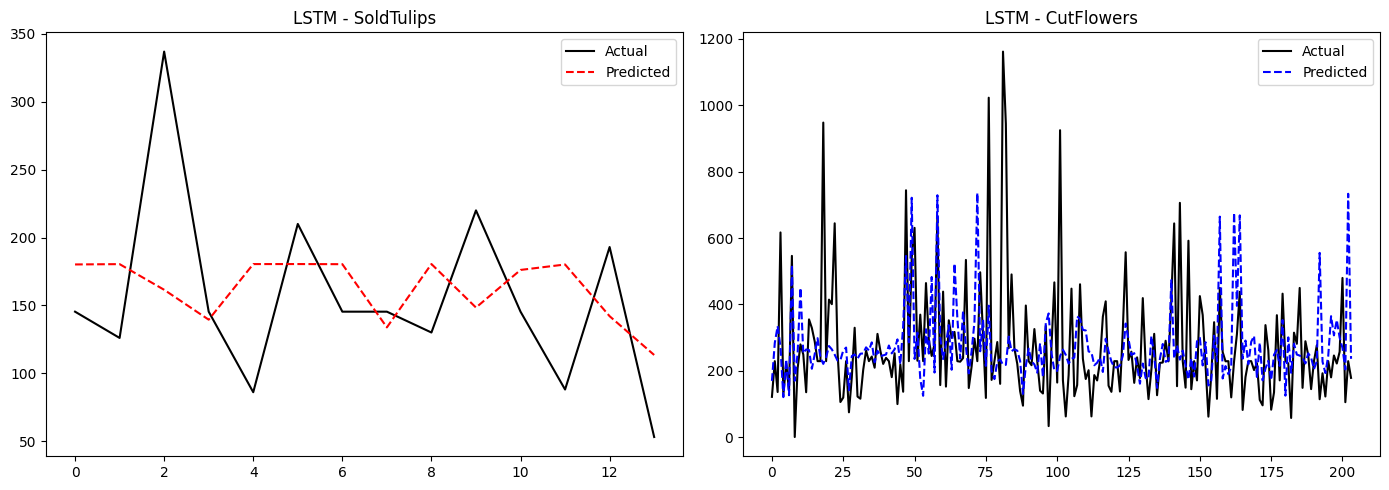

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# --- Load datasets ---
owndoc = pd.read_csv('OwnDoc_preprocessed.csv')
cashierdata = pd.read_csv('CashierData_preprocessed.csv')

# --- Convert datetime columns ---
for df in [owndoc, cashierdata]:
    for col in df.columns:
        if 'date' in col.lower() or 'time' in col.lower():
            df[col] = pd.to_datetime(df[col]).map(pd.Timestamp.toordinal)

# --- Encode categorical variables ---
for df in [owndoc, cashierdata]:
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = LabelEncoder().fit_transform(df[col])

# --- Target columns ---
target_owndoc = 'SoldTulips'
target_cashier = 'CutFlowers'

# --- Helper to create sequences ---
def create_sequences(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# --- Prepare data ---
def preprocess_lstm(df, target, time_steps):
    X = df.drop(columns=[target])
    y = df[target]
    y = y.replace(0, np.median(y[y > 0]))  # fix zeros if any
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_seq, y_seq = create_sequences(X_scaled, y.values, time_steps)
    return train_test_split(X_seq, y_seq, test_size=0.15, random_state=42)

# --- Preprocess both datasets ---
time_steps = 5  # can be tuned

X_train_o, X_test_o, y_train_o, y_test_o = preprocess_lstm(owndoc, target_owndoc, time_steps)
X_train_c, X_test_c, y_train_c, y_test_c = preprocess_lstm(cashierdata, target_cashier, time_steps)

# --- LSTM model ---
def build_deep_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

early_stop = EarlyStopping(patience=15, restore_best_weights=True)

# --- Train model on OwnDoc ---
model_owndoc = build_deep_lstm((X_train_o.shape[1], X_train_o.shape[2]))
model_owndoc.fit(X_train_o, y_train_o, validation_split=0.1,
                 epochs=200, batch_size=16, callbacks=[early_stop], verbose=0)

# --- Train model on CashierData ---
model_cashier = build_deep_lstm((X_train_c.shape[1], X_train_c.shape[2]))
model_cashier.fit(X_train_c, y_train_c, validation_split=0.1,
                  epochs=200, batch_size=16, callbacks=[early_stop], verbose=0)

# --- Predictions ---
y_pred_o = model_owndoc.predict(X_test_o).flatten()
y_pred_c = model_cashier.predict(X_test_c).flatten()

# --- Metrics ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# Updated MAPE function with epsilon to reduce extreme values
def mape(y_true, y_pred, epsilon=0.1):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = np.where(np.abs(y_true) < epsilon, epsilon, np.abs(y_true))  # Use epsilon where y_true is too small
    ape = np.abs((y_true - y_pred) / denominator) * 100
    ape = np.clip(ape, 0, 100)  # Clip the MAPE values to prevent extreme values
    return np.round(np.mean(ape), 2)

# --- Print Results ---
print("\n--- OwnDoc_SoldTulips ---")
print(f"RMSE: {rmse(y_test_o, y_pred_o):.2f}")
print(f"sMAPE: {smape(y_test_o, y_pred_o):.2f}")
print(f"MAPE: {mape(y_test_o, y_pred_o):.2f}")

print("\n--- CashierData_CutFlowers ---")
print(f"RMSE: {rmse(y_test_c, y_pred_c):.2f}")
print(f"sMAPE: {smape(y_test_c, y_pred_c):.2f}")
print(f"MAPE: {mape(y_test_c, y_pred_c):.2f}")

# --- Plot ---
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(y_test_o, label='Actual', color='black')
plt.plot(y_pred_o, label='Predicted', color='red', linestyle='dashed')
plt.title("LSTM - SoldTulips")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_c, label='Actual', color='black')
plt.plot(y_pred_c, label='Predicted', color='blue', linestyle='dashed')
plt.title("LSTM - CutFlowers")
plt.legend()

plt.tight_layout()
plt.show()
